# Lec 08B: RNN Network for Part of Speech (POS) Tagging 

In practical, we shall learn how to construct an LSTM Network for Part-of-Speech (POS) Tagging.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

---

# Part-of-Speech Tagging

In this section, we will use an LSTM to get part-of-speech tags.

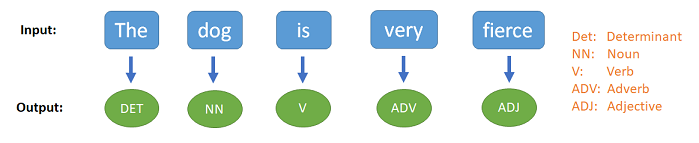

* The input sentence is given by $x^{<1>}, ...x^{<T>}$, where $x^{<t>} \in V_{in}$ where $V_{in}$ is our vocab. 

* The output sequence is given by $y^{<1>},...,y^{<T>}$, where $y^{<i>} \in V_{tag}$ where $V_{tag}$ be our tag set, and $y^{<t>}$ is the predicted tag of word $x^{<t>}$. 
* The tag vocabulary is given by $V_{tag}$ = `["DET", "NN", "V", "ADJ", "ADV"]` where `DET` represents determiner (e.g., "the"), `NN` represents noun or pronouns (e.g., "dog" or "he"), `V` represents verb (e.g., "jumps"), `ADJ` represents adjuective (e.g., `friendly`) and `ADV` represents adverb (e.g., "very").


---
# 2. Preprocessing

## Create the training set

We shall use only four sentences as our training data.

In [2]:
raw_inputs = (
    "the dog happily ate the big apple", 
    "the boy quickly drink the water",
    "everybody read that good book quietly in the hall",
    "she buys her book successfully in the bookstore",
    "the old head master sternly scolded the naughty children for being very loud",
    "i love you loads",
    "he reads the book",
    "she reluctantly wash the dishes",
    "he kicks the ball",
    "she is kind",
    "he is naughty"
)

raw_targets = (
    "DET NN ADV V DET ADJ NN",
    "DET NN ADV V DET NN",
    "NN V DET ADJ NN ADV PRP DET NN",
    "PRN V ADJ NN ADV PRP DET NN",
    "DET ADJ ADJ NN ADV V DET ADJ  NN PRP V ADJ NN",
    "PRN V PRN ADV",
    "PRN V DET NN",
    "PRN ADV V DET NN",
    "PRN V DET NN",
    "PRN V ADJ",
    "PRN V ADJ"
)

Add the padding to ensure all samples are of the same length

In [3]:
def add_padding(inputs, targets = None):

    # compute the max length of all sentence in x
    max_seqlen = max([len(sentence.split(' ')) for sentence in inputs])
    
    # add padding to the inputs
    padded_inputs = []
    for input in inputs: 
        padded_inputs.append(input + ''.join([' PAD']*(max_seqlen - len(input.split(' ')))))
    
    # add padding to the targets
    padded_targets = []
    if targets is not None:
        for target in targets:
            padded_targets.append(target + ''.join([' -']*(max_seqlen - len(target.split(' ')))))            
        return padded_inputs, padded_targets
    
    return padded_inputs


In [4]:
train_feas, train_labels = add_padding(raw_inputs, raw_targets)

In [5]:
train_feas

['the dog happily ate the big apple PAD PAD PAD PAD PAD PAD',
 'the boy quickly drink the water PAD PAD PAD PAD PAD PAD PAD',
 'everybody read that good book quietly in the hall PAD PAD PAD PAD',
 'she buys her book successfully in the bookstore PAD PAD PAD PAD PAD',
 'the old head master sternly scolded the naughty children for being very loud',
 'i love you loads PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 'he reads the book PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 'she reluctantly wash the dishes PAD PAD PAD PAD PAD PAD PAD PAD',
 'he kicks the ball PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 'she is kind PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 'he is naughty PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD']

In [6]:
train_labels

['DET NN ADV V DET ADJ NN - - - - - -',
 'DET NN ADV V DET NN - - - - - - -',
 'NN V DET ADJ NN ADV PRP DET NN - - - -',
 'PRN V ADJ NN ADV PRP DET NN - - - - -',
 'DET ADJ ADJ NN ADV V DET ADJ  NN PRP V ADJ NN',
 'PRN V PRN ADV - - - - - - - - -',
 'PRN V DET NN - - - - - - - - -',
 'PRN ADV V DET NN - - - - - - - -',
 'PRN V DET NN - - - - - - - - -',
 'PRN V ADJ - - - - - - - - - -',
 'PRN V ADJ - - - - - - - - - -']

## Create the vocabularies

Create a dictionary to map words into indices, and vice versa. We shall create 4 structures to do this:
1. `word_to_ix`: dictionary to map a word in an input sentence to its unique index
2. `ix_to_word`: dictionary to map an input index to its correponding word
3. `ix_to_tag`: dictionary to map a tag (output label) to its unique index
4. `tag_to_ix`: dictionary to map a n output index to its correponding tag

The following code gets all the words in `training_data` and assign a unique index to represent the word and store the mapping in the dictionary `word_to_ix`.

In [7]:
def get_vocab(sentences):
    word_to_ix = {}
    tag_to_ix = {}
    
    for sentence in sentences:
        for word in sentence.split():
            if word not in word_to_ix and word != 'PAD':  # word has not been assigned an index yet
                word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique 
    word_to_ix['PAD'] = len(word_to_ix)

    return word_to_ix

In [8]:
word_to_ix = get_vocab(train_feas)

In [9]:
word_to_ix['happily']

2

Add the following additional words which does not exist in the training set to expand our vocabulary set. We may encounter them in the test set.

Now, let's create the `ix_to_word` which allows us to get back our sentence given a list of indices.

In [10]:
ix_to_word = {ix : word for word, ix in word_to_ix.items() } 

In [11]:
ix_to_word[2]

'happily'

Next, let's create  `tag_to_ix` to map the tags to indices  and `ix_to_tag` to map the indices back to the tags

In [12]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "ADJ": 3, "ADV": 4, "PRP": 5, "PRN": 6, "-": 7} 

In [13]:
ix_to_tag = {ix : tag for tag, ix in tag_to_ix.items() }

## Converting a sentence to a list of indices

The function `encode_one_sentence (sentence, to_ix)`
* Receives a sentence (*string*) and  converts all the words in the sentence into its corresponding index (integer). 
* The output is a 1-D integer tensor
* For example: 
<center> <i>everybody read that good book quietly in the hall</i>  --> [6, 7, 8, 9, 10, 11, 12, 0, 13] <center>

The function `encode (sentences, to_ix)`
* receives a *list* of sentences
* outputs a *list* of 1-D integer tensor to represent `sentences`

In [14]:
def encode_one_sentence(seq, to_ix):
    idxs = [to_ix[w] for w in seq.split()]
    return torch.tensor(idxs, dtype=torch.long)

def encode(sentences, to_ix):
    encoded = []
    for sentence in sentences:
        converted = encode_one_sentence(sentence, to_ix)
        encoded.append(converted)
    encoded = torch.stack(encoded)
    return encoded

Create the input matrix `X` by converting the set of sentences into their index form

In [15]:
X = encode (train_feas, word_to_ix)   

In [16]:
print("Number of samples in X:", len(X), '\n')
for i, (ori, x) in enumerate(zip(raw_inputs, X)):
    print(f'Sentence {i}: "{ori}"')
    print(f'    -> {x.detach().numpy()}')

Number of samples in X: 11 

Sentence 0: "the dog happily ate the big apple"
    -> [ 0  1  2  3  0  4  5 47 47 47 47 47 47]
Sentence 1: "the boy quickly drink the water"
    -> [ 0  6  7  8  0  9 47 47 47 47 47 47 47]
Sentence 2: "everybody read that good book quietly in the hall"
    -> [10 11 12 13 14 15 16  0 17 47 47 47 47]
Sentence 3: "she buys her book successfully in the bookstore"
    -> [18 19 20 14 21 16  0 22 47 47 47 47 47]
Sentence 4: "the old head master sternly scolded the naughty children for being very loud"
    -> [ 0 23 24 25 26 27  0 28 29 30 31 32 33]
Sentence 5: "i love you loads"
    -> [34 35 36 37 47 47 47 47 47 47 47 47 47]
Sentence 6: "he reads the book"
    -> [38 39  0 14 47 47 47 47 47 47 47 47 47]
Sentence 7: "she reluctantly wash the dishes"
    -> [18 40 41  0 42 47 47 47 47 47 47 47 47]
Sentence 8: "he kicks the ball"
    -> [38 43  0 44 47 47 47 47 47 47 47 47 47]
Sentence 9: "she is kind"
    -> [18 45 46 47 47 47 47 47 47 47 47 47 47]
Sentence 10: 

Convert the output tags into their index form as well.

In [17]:
Y = encode(train_labels, tag_to_ix)
Y 

tensor([[0, 1, 4, 2, 0, 3, 1, 7, 7, 7, 7, 7, 7],
        [0, 1, 4, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7],
        [1, 2, 0, 3, 1, 4, 5, 0, 1, 7, 7, 7, 7],
        [6, 2, 3, 1, 4, 5, 0, 1, 7, 7, 7, 7, 7],
        [0, 3, 3, 1, 4, 2, 0, 3, 1, 5, 2, 3, 1],
        [6, 2, 6, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [6, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [6, 4, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7],
        [6, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [6, 2, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [6, 2, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]])

In [18]:
for i, x in enumerate(Y):
    print(f'Y{i}:')
    print(f'   {list(x.numpy())}')
    print(f'   -> {[ix_to_tag[i] for i in x.numpy()]}')

Y0:
   [0, 1, 4, 2, 0, 3, 1, 7, 7, 7, 7, 7, 7]
   -> ['DET', 'NN', 'ADV', 'V', 'DET', 'ADJ', 'NN', '-', '-', '-', '-', '-', '-']
Y1:
   [0, 1, 4, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7]
   -> ['DET', 'NN', 'ADV', 'V', 'DET', 'NN', '-', '-', '-', '-', '-', '-', '-']
Y2:
   [1, 2, 0, 3, 1, 4, 5, 0, 1, 7, 7, 7, 7]
   -> ['NN', 'V', 'DET', 'ADJ', 'NN', 'ADV', 'PRP', 'DET', 'NN', '-', '-', '-', '-']
Y3:
   [6, 2, 3, 1, 4, 5, 0, 1, 7, 7, 7, 7, 7]
   -> ['PRN', 'V', 'ADJ', 'NN', 'ADV', 'PRP', 'DET', 'NN', '-', '-', '-', '-', '-']
Y4:
   [0, 3, 3, 1, 4, 2, 0, 3, 1, 5, 2, 3, 1]
   -> ['DET', 'ADJ', 'ADJ', 'NN', 'ADV', 'V', 'DET', 'ADJ', 'NN', 'PRP', 'V', 'ADJ', 'NN']
Y5:
   [6, 2, 6, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7]
   -> ['PRN', 'V', 'PRN', 'ADV', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Y6:
   [6, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7]
   -> ['PRN', 'V', 'DET', 'NN', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Y7:
   [6, 4, 2, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7]
   -> ['PRN', 'ADV', 'V', 'DET', 'NN', '-', '-'

--
# 3. Create the RNN Network

In this section, we create the following LSTM network. 

| No|Layer|Configuration|Output shape| 
| :---:|:---:|:---|:---|
| - | (Input)   | - | `(batch_size, seq_len)`|  
| 1 | Embedding | num_embedding = in_vocab_size (=48)<br> embedding_size = 64| `(batch_size, seq_len, embedding_size)`|  
| 2 | RNN | input_size = embedding_size <br> hidden_size = 32 <br> layer_num=1 <br> batch_first=`True` |`(batch_size, seq_len, hidden_size)` | 
| 3 | FC | in_features = lstm_hidden_size (=32) <br> out_features = out_vocab_size (=8)  <br> activation = log_softmax | `(batch_size, seq_len, out_vocab_size)` |


* **Input**: 
    * Input is a tensor of shape `(batch_size, seq_len)` where each sample is a sequence of words of length `seq_len`. Each sample is a list of integers and all samples have the same length.

* **Embedding Layer**:
    * Converts each word (an *integer*) into an embedding vector of length `embedding_size`. 
    * The output of the layer has a shape of `(batch_size, seq_len, embedding_size)`. 
    
* **RNN Layer**: 
    * `hidden_size` is the number of computational units 
    * The layer receives the input of shape `(batch_num, seq_len, embedding_size)` from the embedding layer. 
    * At each time step, the LSTM outputs an output vector of length `hidden_size`. Hence, the output of the LSTM layer has a shape `(batch_size, seq_len, hidden_size)`.

* **FC (Linear) Layer**:
    * Outputs the tags, one for each time step. 
    * `out_vocab_size` is the number of possible tags (output classes)
    * The [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer is able to process both multiple dimensional data (in our case, both the *batch* and *sequence*) simultaneously where the input is tensor of shape `(batch_size, *, in_features)` whereas the output is a tensor of shape `(batch_size, *, out_features)`
    * The layer has *no* activation.

In [19]:
embedding_size    = 64
lstm_hidden_size  = 32
in_vocab_size     = len(word_to_ix)
out_vocab_size    = len(tag_to_ix)

In [23]:
class POSTagger(nn.Module):
    
    def __init__(self, embedding_size, lstm_hidden_size, in_vocab_size, out_vocab_size):
        
        super().__init__()
        
        # embedding layer
        self.word_embeddings = nn.Embedding(in_vocab_size, embedding_size)
        
        # lstm layer
        self.rnn = nn.RNN(embedding_size, lstm_hidden_size, batch_first=True)
        
        # fc layer
        self.fc = nn.Linear(lstm_hidden_size, out_vocab_size)

    def forward(self, x):

        # embedding layer
        x        = self.word_embeddings(x)
        
        # lstm layer
        x, _     = self.rnn(x)
        
        # fc layer
        x        = self.fc(x)     

        return x

Create a POSTagger object.

In [24]:
model = POSTagger(embedding_size, lstm_hidden_size, in_vocab_size, out_vocab_size)

Display the model

In [25]:
print(model)

POSTagger(
  (word_embeddings): Embedding(48, 64)
  (rnn): RNN(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=8, bias=True)
)


# Train the model

**Define the loss function**

We shall use the Cross Entropy cost function since this is a multi-class classification task.

In [27]:
loss_function = nn.CrossEntropyLoss()

Typically, the `CrossEntropyLoss` expects `Yhat` to be of shape *(batch_size, output_size)* and `Y` to be of shape *(batch_size,)*. However, the output of the RNN model `Yhat` has a shape of *(batch_size, seq_len, output_size)* and `Y` has a shape of *(batch_size, seq_len)*. To solve the problem, we collapse the *batch* and *time* dimensions as follows:
* `Yhat` from shape *(batch_size, seq_len, output_size)* $\rightarrow$ *(batch_size*seq_len, output_size)*
* `Y` from shape *(batch_size, seq_len)* $\rightarrow$ *(batch_size*seq_len,)*

In [28]:
Yhat = model(X)

In [31]:
Yhat_resized = Yhat.view(-1, Yhat.size(-1))
Y_resized    = Y.view(-1)

In [32]:
loss_function(Yhat_resized, Y_resized)

tensor(2.0369, grad_fn=<NllLossBackward0>)

**Set the optimizer**

In [33]:
optimizer = optim.SGD(model.parameters(), lr=0.5)

**Perform training**

Prepare Y for training

In [34]:
Y = Y.view(-1)

Start training

In [35]:
print("Training Started")
num_epochs = 2000
for epoch in range(num_epochs):
    
    # clear the gradients
    model.zero_grad()

    # Run the forward propagation
    Yhat = model(X)
    
    # Reshape Yhat
    Yhat = Yhat.view(-1, Yhat.size(-1))  
    
    # compute loss
    loss = loss_function(Yhat, Y)
    
    # backpropagation
    loss.backward()

    # update network parameters
    optimizer.step()        
    
    if (epoch+1) % 200 == 0  or epoch == 0 or epoch == num_epochs-1:
        print(f'epoch: {epoch+1}: loss: {loss:.4f}')

Training Started
epoch: 1: loss: 2.0369
epoch: 200: loss: 0.0052
epoch: 400: loss: 0.0023
epoch: 600: loss: 0.0014
epoch: 800: loss: 0.0010
epoch: 1000: loss: 0.0008
epoch: 1200: loss: 0.0007
epoch: 1400: loss: 0.0006
epoch: 1600: loss: 0.0005
epoch: 1800: loss: 0.0004
epoch: 2000: loss: 0.0004


# Performing prediction

Now, let's perform prediction on the following new sentences. 

In [36]:
data1 = ["the boy read that good book in the hall", 
         "she reads the book",
         "the boy scolded the dog", 
         "she happily kicks the ball"]

Pad data1

In [37]:
padded1 = add_padding(data1)
padded1

['the boy read that good book in the hall',
 'she reads the book PAD PAD PAD PAD PAD',
 'the boy scolded the dog PAD PAD PAD PAD',
 'she happily kicks the ball PAD PAD PAD PAD']

Encode data1

In [38]:
X1 = encode(padded1, word_to_ix)
X1

tensor([[ 0,  6, 11, 12, 13, 14, 16,  0, 17],
        [18, 39,  0, 14, 47, 47, 47, 47, 47],
        [ 0,  6, 27,  0,  1, 47, 47, 47, 47],
        [18,  2, 43,  0, 44, 47, 47, 47, 47]])

The function `predict` predicts the tags for the batch sample simultaneously.

In [39]:
def predict(X, padded, ix_to_tag):
    
    with torch.no_grad():
        
        # computes class score
        yhat = model(X)

        # get predicted labels
        _, predicted = torch.max(yhat, -1)

        # for each sample, convert the index back to word
        for sentence, pred in zip(padded, predicted):
            print(f'{sentence}')
            print(f'-->', [ix_to_tag[i] for i in pred.numpy()], '\n')

In [40]:
predict(X1, padded1, ix_to_tag)

the boy read that good book in the hall
--> ['DET', 'NN', 'V', 'DET', 'ADJ', 'NN', 'PRP', 'DET', 'NN'] 

she reads the book PAD PAD PAD PAD PAD
--> ['PRN', 'V', 'DET', 'NN', '-', '-', '-', '-', '-'] 

the boy scolded the dog PAD PAD PAD PAD
--> ['DET', 'NN', 'ADV', 'DET', 'NN', '-', '-', '-', '-'] 

she happily kicks the ball PAD PAD PAD PAD
--> ['PRN', 'V', 'V', 'DET', 'NN', '-', '-', '-', '-'] 



<center> --- End of Lab8B --- </center>